In [4]:
from huggingface_hub import snapshot_download

# Load datasets
download_path = "/mnt/data0/drs25/data/"
local_dir = snapshot_download(
    repo_id="mburgjr/GelSight-YoungsModulus",  # Hugging Face dataset repo
    repo_type="dataset",
    local_dir=download_path
)
print("Dataset downloaded to:", local_dir)
"""download_path = "/mnt/data0/drs25/data/"
local_dir = snapshot_download(
    repo_id="facebook/gelsight-force-estimation",  # Hugging Face dataset repo
    repo_type="dataset",
    local_dir=download_path
)
print("Dataset downloaded to:", local_dir)
"""
#files will need to be manually unzipped

Fetching 3 files: 100%|██████████| 3/3 [05:53<00:00, 117.69s/it]


Dataset downloaded to: /mnt/data0/drs25/data


Fetching 91 files: 100%|██████████| 91/91 [06:38<00:00,  4.38s/it]

Dataset downloaded to: /mnt/data0/drs25/data


## Inspect and Process data

17288 17288
dict_keys(['indexes', 'forces', 'forces_slip', 'poses', 'delta_forces', 'delta_mag_shear', 'delta_mag_normal', 'slip_label', 'coef_friction'])
23


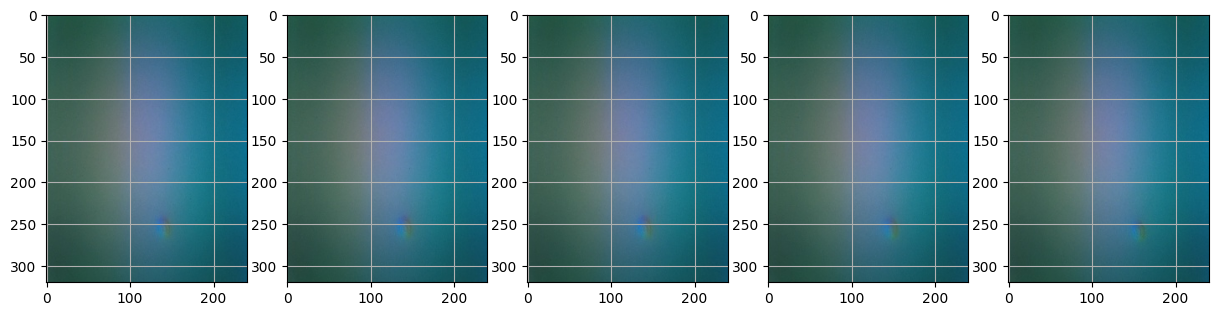

[[-0.00443221 -0.00231041  0.16037084]
 [-0.00479696 -0.00231752  0.16415005]
 [-0.00513948 -0.00239047  0.16759209]
 [-0.00555316 -0.00245987  0.17168356]
 [-0.00594638 -0.00247944  0.17545832]
 [-0.00623107 -0.00250969  0.17807744]
 [-0.00645348 -0.00252748  0.1803398 ]
 [-0.0065976  -0.00249456  0.18148655]
 [-0.00664386 -0.00246076  0.18154171]
 [-0.00500514  0.00342602  0.18141805]
 [-0.00139763  0.03252095  0.18130062]
 [ 0.00318849  0.05784023  0.17978021]
 [ 0.00862065  0.08510249  0.17810946]
 [ 0.01321478  0.11150001  0.17622075]
 [ 0.0155928   0.12676631  0.17118536]
 [ 0.01630184  0.121295    0.16517492]
 [ 0.01587392  0.11696332  0.15883532]
 [ 0.01452166  0.10722171  0.15138277]
 [ 0.01443982  0.10135184  0.14364375]
 [ 0.01428146  0.09882614  0.13718138]
 [ 0.01389713  0.0910115   0.13097344]
 [ 0.01374234  0.08870821  0.12629391]
 [ 0.01294877  0.08706949  0.1206758 ]]


In [133]:
print(len(forces['in_contact']),len(frames)+len(frames1)+len(frames2)+len(frames3))
all_frames = frames + frames1 + frames2 + frames3
print(forces['trajectories'][1].keys())
trajectory = forces['trajectories'][2]
traj_frames = [load_bin_image(all_frames[i]) for i in trajectory['indexes']]
traj_forces = trajectory['forces']
traj_slip = trajectory['slip_label']

assert len(traj_frames) == len(traj_forces) == len(traj_slip)
print(len(traj_frames))
plt.figure(figsize=(15,5))
for i,j in enumerate(range(0,len(traj_frames),4)):
    try:
        plt.subplot(1,len(traj_frames)//4,i+1)
        #plt.axis("off")
        plt.imshow(traj_frames[j])
        plt.grid(True)
    except:
        pass

plt.show()


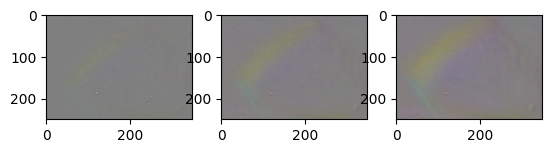

array([ 7.69503348, 12.31077621, 26.4009184 ])

In [13]:
import pickle
import matplotlib.pyplot as plt
def load_pickle_dataset(file_dataset):
    with open(file_dataset, "rb") as f:
        all_frames = pickle.load(f)
    return all_frames

example_file="/mnt/data0/drs25/data/gelsight_youngs_modulus_dataset/foam_rod/grasp=0/augmentation=0/RGB.pkl"
p=load_pickle_dataset(example_file)
plt.subplot(1,3,1)
plt.imshow(p[0])
plt.subplot(1,3,2)
plt.imshow(p[1])
plt.subplot(1,3,3)
plt.imshow(p[2])
plt.show()
example_file="/mnt/data0/drs25/data/gelsight_youngs_modulus_dataset/foam_rod/grasp=0/augmentation=0/forces.pkl"
p=load_pickle_dataset(example_file)
p



# sort data

In [1]:
import os
import pickle
import cv2
import numpy as np
import io
import matplotlib.pyplot as plt
def load_pickle_dataset(file_dataset):
    with open(file_dataset, "rb") as f:
        all_frames = pickle.load(f)
    return all_frames

def load_bin_image(io_buf):
    # Convert bytes buffer to a NumPy array
    nparr = np.frombuffer(io_buf, np.uint8)
    # Decode image with OpenCV
    img = cv2.imdecode(nparr, cv2.IMREAD_UNCHANGED)  # keeps original channels
    return img


In [64]:
def loadData(path):
    forces=load_pickle_dataset(path+'dataset_slip_forces.pkl')
    other_file = [f for f in os.listdir(path) if "org" not in f and "slip" not in f]
    other_file.sort()
    #get other files
    images=[]
    for i in range(len(other_file)):
        images+=load_pickle_dataset(path+other_file[i])
    temp=[]
    y=[]
    min_=100
    for event in forces['trajectories']:
        trajectory=forces['trajectories'][event]
        in_contact=forces['in_contact']
        traj_forces = trajectory['forces']
        traj_slip = trajectory['slip_label']
        #print(len(trajectory['indexes']),len(traj_slip),len(in_contact))
        #assert len(trajectory['indexes']) == len(traj_forces),"oh dear"
        temp.append([load_bin_image(images[i]) for i in trajectory['indexes']])
        y.append([traj_forces,traj_slip])
        if len(temp[-1])<min_:min_=len(temp[-1])
    #now the reshuffle 
    X, force, slip = [], [], []
    for seq, label in zip(temp, y):
        n = len(seq)
        offset = len(seq) - len(label[0])  # usually 5
        # cut into chunks of size min_
        for i in range(0, n, min_):
            chunk = seq[i:i+min_]
            if len(chunk) == min_- offset:   # keep only full-size chunks
                X.append(chunk)
                force.append(label[0][i:i+min_])
                slip.append(label[1][i:i+min_])

    print(len(seq),len(label[0]))
    X=np.array(X)
    force=np.array(force)
    slip=np.array(slip)
    return X,force,slip

X,force,slip=loadData("/mnt/data0/drs25/data/FORCE/flat/batch_1/")
#"/mnt/data0/drs25/data/FORCE/sphere/batch_1/"
print(X.shape)
print(force.shape)
print(slip.shape)

37 32
(11, 6, 320, 240, 3)
(11, 1, 3)
(11, 1)


In [ ]:
import os
def generate_dataset(parent):
    other_file = [f for f in os.listdir(parent) if "." not in f and "assets" not in f]
    X=[]
    y=[]
    for i,objects in enumerate(other_file): #loop through files
        object_path=parent+"/"+objects+"/"
        batches=os.listdir(object_path)
        for batch in batches: #loop through batches
            try:
                a,b,c=loadData(object_path+batch+"/") #gather and label data
                X.append(a)
                y_prime=[]
                for j in range(len(b)):
                    y_prime.append(objects+" shape, force "+str(np.average(b[j]))+" newtons, slip "+str(int(np.max(c[j]))))
                y+=y_prime
                print(object_path+batch,"passed")
            except Exception as e:
                print(object_path+batch,"failed")
                #print(e)
    sizes=[]
    for i in range(len(X)):
        sizes.append(X[i].shape[1])
    min_=min(sizes)
    for i in range(len(X)):
        X[i]=X[i][:,:min_]
    X = np.concatenate(X, axis=0)
    return X,y


37 32
/mnt/data0/drs25/data/FORCE//flat/batch_1 passed
33 28
/mnt/data0/drs25/data/FORCE//flat/batch_2 passed
101 96
/mnt/data0/drs25/data/FORCE//sharp/batch_1 passed
114 109
/mnt/data0/drs25/data/FORCE//sharp/batch_2 passed
49 49
/mnt/data0/drs25/data/FORCE//sphere/batch_1 passed
20 20
/mnt/data0/drs25/data/FORCE//sphere/batch_2 passed
98 98
/mnt/data0/drs25/data/FORCE//sphere/batch_3 passed
63 63
/mnt/data0/drs25/data/FORCE//sphere/batch_4 passed
88 88
/mnt/data0/drs25/data/FORCE//sphere/batch_5 passed
89 89
/mnt/data0/drs25/data/FORCE//sphere/batch_6 passed


In [36]:

def recurrent_step(path):
    X=[]
    y=[]
    if os.path.exists(path):
        pathe=[f for f in os.listdir(path) if "org" not in f and "slip" not in f]
        for p in pathe:
            if ".pkl" not in p:
                x,y_=recurrent_step(path+"/"+p+"/")
                X+=x 
                y+=y_
            else:
                X.append(load_pickle_dataset(path+"/RGB.pkl").astype(np.uint8))
                y.append([load_pickle_dataset(path+"/forces.pkl"),
                        load_pickle_dataset(path+"/elastic_estimate.pkl")])
    return X,y

def gointodata(path):
    textures = [f for f in os.listdir(path) if "org" not in f and "slip" not in f]
    X=[]
    y=[]
    for texture in textures[0:100]:
        x,y_=recurrent_step(path+"/"+texture)
        X+=x
        for i in range(len(x)):
            y.append("Texture "+texture+", force "+str(np.average(y_[i][0]))+", elastic force "+str(np.average(y_[i][1])))
        print("done",texture)
    print(len(X))
    print(len(y))
    return np.array(X),y
x,y=gointodata("/mnt/data0/drs25/data/gelsight_youngs_modulus_dataset/")  

done acrylic_hex
done acrylic_piece
done allen_key
done allen_key_medium
done allen_key_small
done aluminum_cylinder
done aluminum_cylinder_etched
done aluminum_cylinder_wide
done aluminum_hex
done aluminum_horse
done aluminum_plate_waterjet
done aluminum_square
done aluminum_square_rod
done aluminum_stand
done angle_bracket
done angle_bracket_long
done apple
done baby_lego_1
done baby_lego_2
done baby_lego_3
done baby_toy_star
done baby_toy_triangle
done baby_toy_x
done ball_string_toy
done banana_eraser
done baseball
done bear_eraser
done bearing_large
done bearing_small
done bee_eraser
done black_donut_indenter
done black_foam
done blue_bottle_cap
done blue_elastic_ball
done blue_foam_brick
done blue_sponge_dry
done blue_sponge_wet
done bolt_black
done bolt_black_big
done bolt_black_small
done bolt_gray
done bolt_gray_long
done bolt_gray_massive
done bolt_gray_small
done bowl_big_plastic
done bowl_ceramic
done bowl_small_plastic
done brass_connector
done brass_fitting_1
done brass_f

In [38]:
print(x.shape)
print(len(y),y[0])

(10960, 3, 250, 350, 3)
10960 Texture acrylic_hex, force 19.386136263923447, elastic force 72969844769.11276


In [ ]:
x,y=generate_dataset("/mnt/data0/drs25/data/FORCE/")
x,y=gointodata("/mnt/data0/drs25/data/gelsight_youngs_modulus_dataset/")  

## Visualise dataset

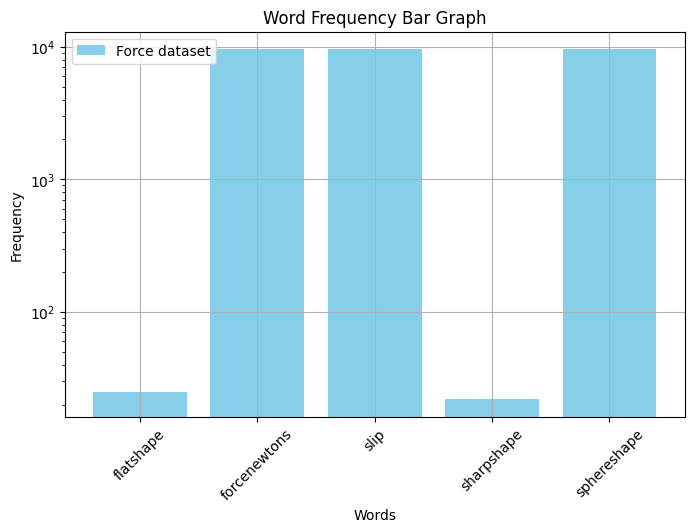

In [ ]:
import re
import matplotlib.pyplot as plt
classes={}
for i in range(len(y)):
    string=y[i]
    cleaned = re.sub(r"\d+(\.\d+)?", "", string).replace("-","").replace(" ","")
    data=cleaned.split(",")
    for item in data:
        if classes.get(item,"wrong")!="wrong":
            classes[item]+=1
        else:
            classes[item]=1

plt.figure(figsize=(8, 5))
plt.bar(classes.keys(), classes.values(), color="skyblue",label="Force dataset")

# Labels and title
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.yscale("log")
plt.title("Word Frequency Bar Graph")
plt.xticks(rotation=45)
plt.grid(1)
plt.legend(loc="upper left")
plt.savefig("/its/home/drs25/Tactile_Language_Model/data/plots/wordfreq.pdf")
plt.show()